In [1]:
import plot_results as my

/Users/coulaud/opt/anaconda3/envs/DL-normalization/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
pwd

'/Users/coulaud/Documents/DL-normalization/notebooks'

In [3]:
p = my.Plots("../../epoch=2757-val_loss=0.00001.ckpt",
             "../data/processed/isotropic_noise99_samples_standardize/",
            "cnn")

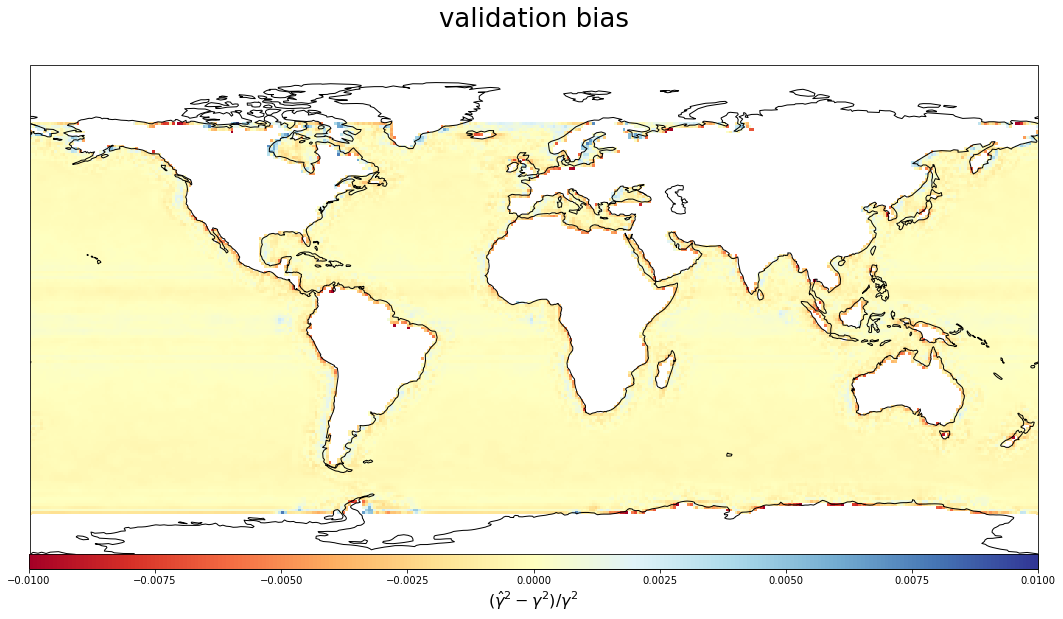

mean:  0.00045850477974790826
max:  0.023902512098193576


In [4]:
p.validation_bias()

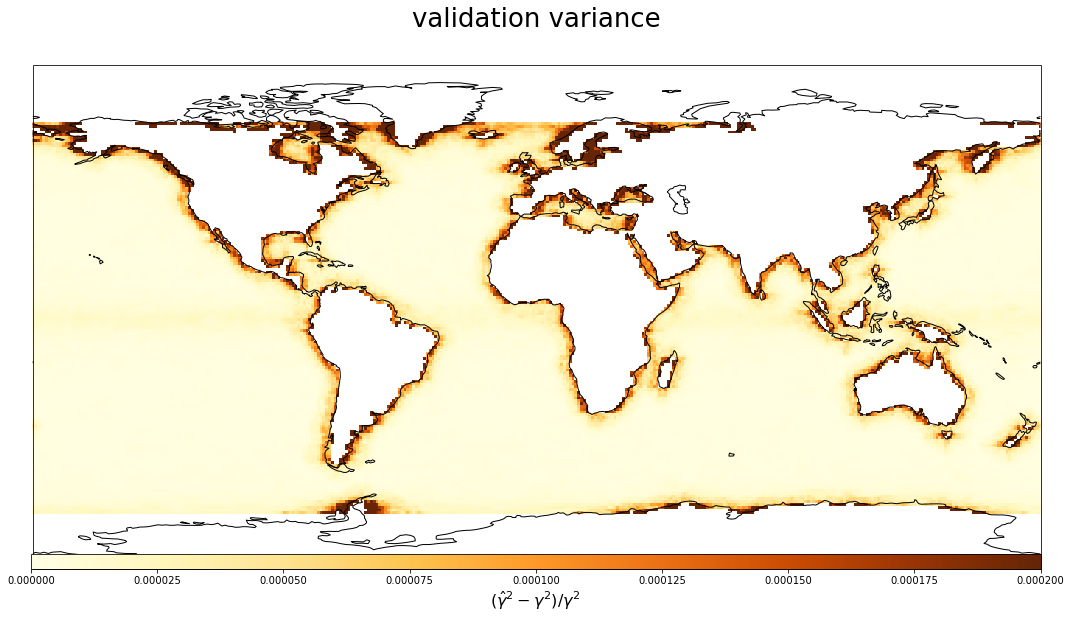

mean:  3.2964472901956254e-05
max:   0.0038545489737781997
min:   2.089123049415911e-06


In [5]:
p.validation_var()

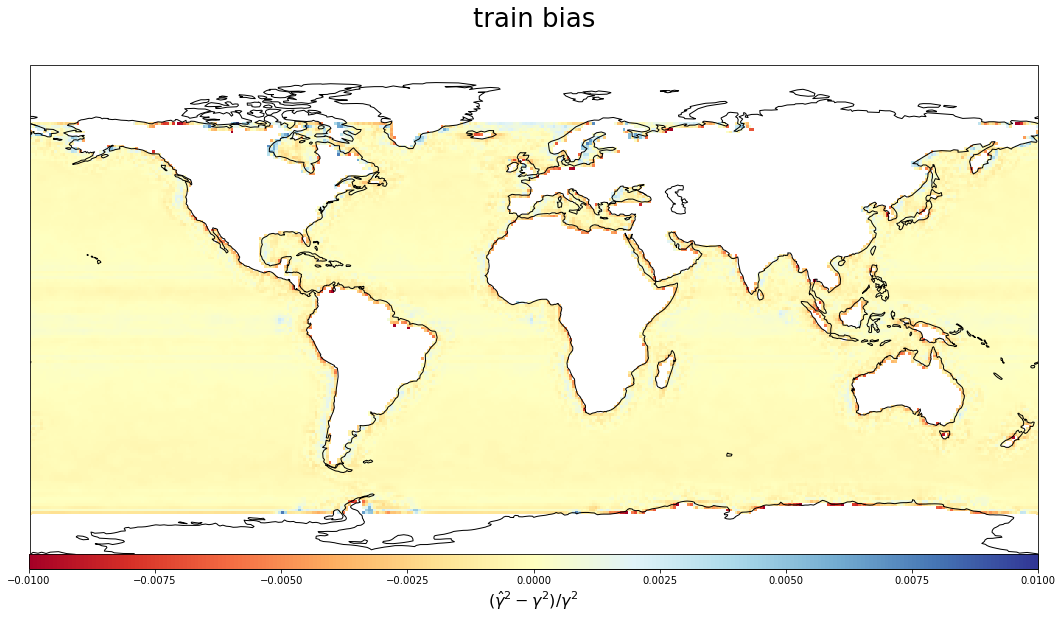

mean:  0.00045850477974790826
max:  0.023902512098193576


In [6]:
p.train_bias()